In [1]:
import tensorflow as tf
import numpy as np
import time
from arc import *
from qutip import *

from quantum_optimal_control.state_transfer.propagator_vl import PropagatorVL
from quantum_optimal_control.toolkits.plotting_helper import *


2025-03-04 08:07:38.092813: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-04 08:07:38.095257: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-04 08:07:38.144363: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-04 08:07:38.145609: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-04 08:07:38.991376: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [10]:
atom = Rubidium87()

# Intermediate excited state: 6P3/2
n_i = 6
l_i = 1
j_i = 1.5
T_i = atom.getStateLifetime(n_i, l_i, j_i)
Gamma_ig = 1/T_i  # Decay rate of intermediate state

# Rydberg state: 70 S1/2
n_r = 70
l_r = 0
j_r = 0.5
# Account for blackbody stimulation of Rydberg state to nearby states
# Total lifetime is blackbody + radiative: 1/T_rtotal = 1/T_rBB + 1/T_rRadiative
T_rTot = atom.getStateLifetime(n_r, l_r, j_r, temperature=300, includeLevelsUpTo=n_r + 50)
# Radiative lifetime: decay to other ground state (so at 0 K temp)
T_rRad = atom.getStateLifetime(n_r, l_r, j_r, temperature=0)
# Radiative transition from rydberg to intermediate
T_ri = 1/atom.getTransitionRate(n_r, l_r, j_r, n_i, l_i, j_i, temperature=0)
T_rgp = 1/(1/T_rRad - 1/T_ri)  # radiative transition: rydberg to dark ground sates

# Black body stimulated: Transition from rydberg to nearby rydberg
T_rBB = 1/(1/T_rTot - 1/T_rRad)

# Set decay rate to each state
Gamma_ri = 1/T_ri
Gamma_rrp = 1/T_rBB  # r to r' (r prime)
Gamma_rgp = 1/T_rgp  # rydberg to g' (ground prime dark states)

Gamma_rTot = Gamma_ri + Gamma_rrp + Gamma_rgp  # Total decay from Rydberg


# Set system parameters:
Rabi_1 = 2 * np.pi * 127e6  # Blue Rabi freq.
Rabi_2 = 2 * np.pi * 127e6  # Red Rabi freq.
Delta_1 = 0  # Detuning for 3 lvl system at the i state
del_total = 0  # 2 photon detuning

# Set time grid:
t_0 = 0  # Initial time
t_f = 100e-9  # Final time
nt = 1000  # number of time points
delta_t = (t_f - t_0)/nt  # time difference between steps
tlist = np.linspace(0, t_f, nt)

# Set number of basis functions for the control amplitudes
input_dim = 10  # (number of Gaussian modes)

# Set number of iterations in the optimization:
num_iters = 1250
learn_rate = 0.1

# set random seed
seed = 1
tf.random.set_seed(seed=seed)


step 0: Figure of Merit = 0.79957


step  1: Figure of Merit = 0.80509
step 50: Figure of Merit = 0.00316
step 100: Figure of Merit = 0.00162
step 150: Figure of Merit = 0.00141
step 200: Figure of Merit = 0.00130
step 250: Figure of Merit = 0.00122
step 300: Figure of Merit = 0.00116
step 350: Figure of Merit = 0.00109
step 400: Figure of Merit = 0.00113
step 450: Figure of Merit = 0.00102
step 500: Figure of Merit = 0.00096
step 550: Figure of Merit = 0.00091
step 600: Figure of Merit = 0.00087
step 650: Figure of Merit = 0.00083
step 700: Figure of Merit = 0.00079
step 750: Figure of Merit = 0.00075
step 800: Figure of Merit = 0.00072
step 850: Figure of Merit = 0.00070
step 900: Figure of Merit = 0.00068
step 950: Figure of Merit = 0.00067
step 1000: Figure of Merit = 0.00066
step 1050: Figure of Merit = 0.00065
step 1100: Figure of Merit = 0.00064
step 1150: Figure of Merit = 0.00063
step 1200: Figure of Merit = 0.00062
step 1250: Figure of Merit = 0.00061
Run Time: 75.6060 seconds
Best figure of merit: 0.00061


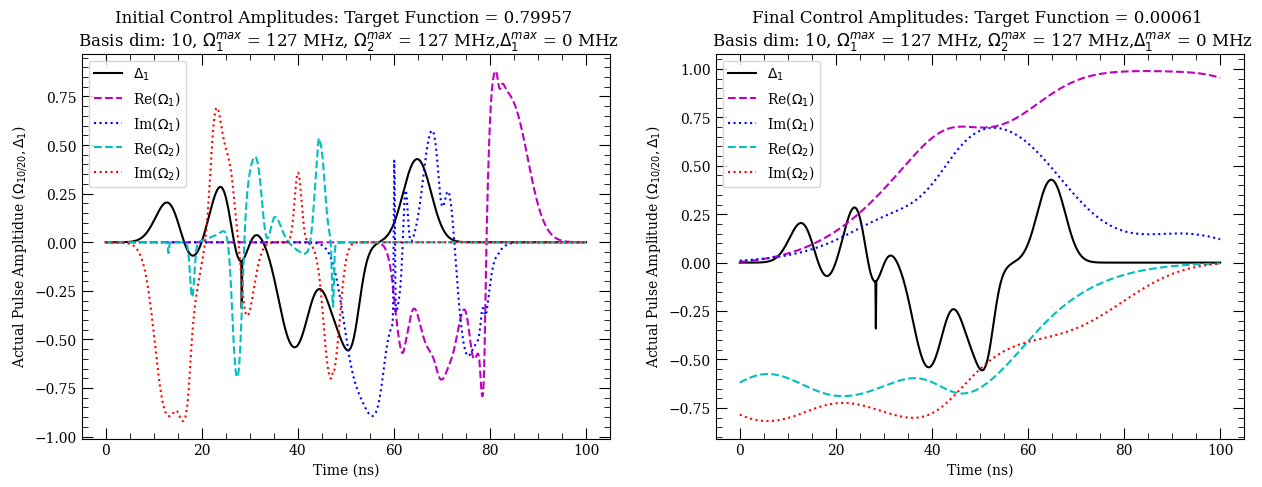

In [11]:

# Set propagator
propagatorVL = PropagatorVL(
    input_dim, nt, delta_t, del_total, Delta_1, Rabi_1, Rabi_2,
    Gamma_rTot, Gamma_ig
)

# Set initial control amplitude guess seeding:
numb_ctrl_amps = 5  # number of control amplitudes (Delta_1, Rabi_1X2, Rabi_2X2)
propagatorVL.ctrl_amplitudes_a.assign(
    tf.random.uniform([input_dim, numb_ctrl_amps], -1, 1, dtype=tf.float64)
)
# Initialize Gaussian peaks to be Rabi_2 before Rabi_1:
# (Keep Delta uniform random)
propagatorVL.ctrl_amplitudes_b[:, 0].assign(
    tf.random.uniform([input_dim], -1, 1, dtype=tf.float64)
)
propagatorVL.ctrl_amplitudes_b[:, 1:3].assign(
    tf.random.uniform([input_dim, 2], 0, 1, dtype=tf.float64)
)
propagatorVL.ctrl_amplitudes_b[:, 3:5].assign(
    tf.random.uniform([input_dim, 2], -1, 0, dtype=tf.float64)
)

propagatorVL.ctrl_amplitudes_c.assign(
    tf.random.uniform([input_dim, numb_ctrl_amps], 0, 0.1, dtype=tf.float64)
)

# Find infidelity using propagator
initial_infidelity = propagatorVL.target()

# Plot initial guess pulses:
labels = [
    '$\Delta_1$', 'Re($\Omega_1$)', 'Im($\Omega_1$)',
    'Re($\Omega_2$)', 'Im($\Omega_2$)'
]
colors = ['k', 'm--', 'b:', 'c--', 'r:']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ind = 0
physical_amplitudes_initial = propagatorVL.return_physical_amplitudes().numpy()

for amplitude in tf.transpose(physical_amplitudes_initial):
    # Plotting actual physical input amplitudes:
    ax1.plot(tlist/1e-9, amplitude, colors[ind], label=labels[ind])
    ind += 1
ax1.set_title(
    'Initial Control Amplitudes: Target Function = %2.5f \n \
Basis dim: %.0f, $\Omega_1^{max}$ = %.0f MHz, $\Omega_2^{max}$ = %.0f MHz,\
$\Delta_1^{max}$ = %.0f MHz'
    % (initial_infidelity, input_dim, Rabi_1/(2 * np.pi * 1e6), Rabi_2/(2 * np.pi * 1e6),
       Delta_1/(2 * np.pi * 1e6)
       ), fontsize=12
)
ax1.set_ylabel('Actual Pulse Ampltidue ($\Omega_{10/20}, \Delta_1$)')
ax1.set_xlabel('Time (ns)')
ax1.legend()

# Optimize pulse with gradient accent:
optimizer = tf.keras.optimizers.Adam(learn_rate)


@tf.function
def optimization_step():
    with tf.GradientTape() as tape:
        infidelity = propagatorVL.target()
    gradients = tape.gradient(infidelity, [propagatorVL.ctrl_amplitudes_a,
                              propagatorVL.ctrl_amplitudes_b, propagatorVL.ctrl_amplitudes_c])
    optimizer.apply_gradients(zip(gradients, [propagatorVL.ctrl_amplitudes_a,
                              propagatorVL.ctrl_amplitudes_b, propagatorVL.ctrl_amplitudes_c]))
    return propagatorVL.target()


# Measure run time:
start = time.time()

print('step 0: Figure of Merit = %2.5f' %
      (initial_infidelity))
best_infidelity = 1
steps = range(num_iters)
for step in steps:
    current_infidelity = optimization_step()
    if (step + 1) % 50 == 0 or step == 0:
        print('step %2d: Figure of Merit = %2.5f' %
              (step + 1, current_infidelity))
    # keep best result:
    if current_infidelity < best_infidelity:
        best_infidelity = current_infidelity

physical_amplitudes_final = propagatorVL.return_physical_amplitudes().numpy()

# Measure run time:
end = time.time()
print('Run Time: %2.4f seconds' % (end-start))

# Plot final results of control amplitudes
ind = 0
for amplitude in physical_amplitudes_final.T:
    # Plotting final physical amplitudes:
    ax2.plot(tlist/1e-9, amplitude, colors[ind], label=labels[ind])
    ind += 1
ax2.set_title(
    'Final Control Amplitudes: Target Function = %2.5f \n \
Basis dim: %.0f, $\Omega_1^{max}$ = %.0f MHz, $\Omega_2^{max}$ = %.0f MHz,\
$\Delta_1^{max}$ = %.0f MHz'
    % (current_infidelity, input_dim, Rabi_1/(2 * np.pi * 1e6), Rabi_2/(2 * np.pi * 1e6),
       Delta_1/(2 * np.pi * 1e6)
       ), fontsize=12
)
ax2.set_ylabel('Actual Pulse Amplitude ($\Omega_{10/20}, \Delta_1$)')
ax2.set_xlabel('Time (ns)')
ax2.legend()

print('Best figure of merit: %2.5f' % best_infidelity)


In [12]:
##Use final optimized pulse in Master Equation to get actual final fidelity:
def MEsolve_5lvl_t(time, argsME5lvl):
    Rabi_1_Pulse_Re, Rabi_2_Pulse_Re, Rabi_1_Pulse_Im, \
    Rabi_2_Pulse_Im, Delta_1_Pulse, del_total, Gamma_ig, \
    Gamma_ri, Gamma_rrp, Gamma_rgp = argsME5lvl

    def nLevelAtomBasis(n):
        states = []
        for n_l in range(0,n):
            states.append(basis(n, n_l))
        return states
    ##Set 5 lvl operators:
    g_prime, r_prime, g, i, r = nLevelAtomBasis(5) # basis are ground
    
    sig_gpgp = g_prime * g_prime.dag()
    sig_gg = g * g.dag()
    sig_ii = i * i.dag()
    sig_rr = r * r.dag()
    sig_ir = i * r.dag()
    sig_gi = g * i.dag()
    sig_gpi = g_prime * i.dag()
    sig_rpr = r_prime * r.dag()
    sig_gpr = g_prime * r.dag()
    sig_gpgp = g_prime * g.dag()

    ##Set initial state:
    psi0 = g  #initialy in ground state
             
    ##Set decay operators: intermediate state to ground, and Rydberg to i (radiative) and r_prime (blackbody)
    Gamma_rTot = Gamma_ri + Gamma_rrp + Gamma_rgp #Total decay from Rydberg
    ##Set decay operators: intermediate state to ground, and Rydberg to i (radiative) and r_prime (blackbody)
    Decay_ig = np.sqrt(Gamma_ig) * sig_gi
    Decay_ri = np.sqrt(Gamma_ri) * sig_ir
    Decay_rrp = np.sqrt(Gamma_rrp) * sig_rpr #Blackbody stimulated to nearby dark rydberg states
    Decay_rgp = np.sqrt(Gamma_rgp) * sig_gpr #Blackbody stimulated to nearby dark rydberg states

    Decay_ops = [Decay_ig, Decay_ri, Decay_rrp, Decay_rgp]

    ##Set hamiltonian parts:    
    H0 = - del_total * sig_rr
    H0_Delta = - Delta_1 * sig_ii
    H1_re = -1/2 * Rabi_1 * (sig_gi + sig_gi.dag())
    H2_re = -1/2 * Rabi_2 * (sig_ir + sig_ir.dag())
    H1_im = -1/2 * 1j * Rabi_1 * (sig_gi - sig_gi.dag())
    H2_im = -1/2 * 1j * Rabi_2 * (sig_ir - sig_ir.dag())

    H = [H0, [H0_Delta, Delta_1_Pulse], [H1_re, Rabi_1_Pulse_Re],
         [H1_im, Rabi_1_Pulse_Im], [H2_re, Rabi_2_Pulse_Re],
         [H2_im, Rabi_2_Pulse_Im]
         ]
    #Finds expectation of p_rr and p_ii and p_gg:
    result = mesolve(H, psi0, time,  Decay_ops, [sig_rr, sig_ii, sig_gg], args = {}) 
    
    return result


In [13]:
##Test robustness:
#Set percentage of original amplitude:
Percent_amp = 1

#Set actual pulse amplitudes (tanh(ctrl_amplitudes))
Rabi_1_Pulse_real_opt = Percent_amp * physical_amplitudes_final[:,1]
Rabi_1_Pulse_opt_real_S = Cubic_Spline(tlist[0], tlist[-1], Rabi_1_Pulse_real_opt) #interpolated data for time evolution
Rabi_1_Pulse_imag_opt = Percent_amp * physical_amplitudes_final[:,2]
Rabi_1_Pulse_opt_imag_S = Cubic_Spline(tlist[0], tlist[-1], Rabi_1_Pulse_imag_opt) #interpolated data for time evolution

Rabi_2_Pulse_real_opt = Percent_amp * physical_amplitudes_final[:,3]
Rabi_2_Pulse_opt_real_S = Cubic_Spline(tlist[0], tlist[-1], Rabi_2_Pulse_real_opt)
Rabi_2_Pulse_imag_opt = Percent_amp * physical_amplitudes_final[:,4]
Rabi_2_Pulse_opt_imag_S = Cubic_Spline(tlist[0], tlist[-1], Rabi_2_Pulse_imag_opt)

Delta_1_opt = Percent_amp * physical_amplitudes_final[:,0]
Delta_1_opt_S = Cubic_Spline(tlist[0], tlist[-1], Delta_1_opt)

#Set parameters for Hamiltonian
argsME5lvl = [Rabi_1_Pulse_opt_real_S, Rabi_2_Pulse_opt_real_S,
              Rabi_1_Pulse_opt_imag_S, Rabi_2_Pulse_opt_imag_S,
              Delta_1_opt_S, del_total, Gamma_ig, Gamma_ri,
              Gamma_rrp, Gamma_rgp
        ]

#Convert real and imaginary parts of Rabi frequency into amplitude and phase
Rabi_1_amplitude = np.sqrt(Rabi_1_Pulse_opt_real_S(tlist)**2 + Rabi_1_Pulse_opt_imag_S(tlist)**2)
Rabi_1_phase = np.arctan(Rabi_1_Pulse_opt_imag_S(tlist)/Rabi_1_Pulse_opt_real_S(tlist))
Rabi_2_amplitude = np.sqrt(Rabi_2_Pulse_opt_real_S(tlist)**2 + Rabi_2_Pulse_opt_imag_S(tlist)**2)
Rabi_2_phase = np.arctan(Rabi_2_Pulse_opt_imag_S(tlist)/Rabi_2_Pulse_opt_real_S(tlist))
Delta_1_amplitude = Delta_1_opt_S(tlist)
# #Solve Master Equation:
result = MEsolve_5lvl_t(tlist, argsME5lvl)
p_rr = result.expect[0]
p_ii = result.expect[1]
p_gg = result.expect[2]


In [14]:
## Find overlap of the dark state with the actual state over the evolution:
DS_overlap_squared = []
g_overlap_squared = []
i_overlap_squared = []
r_overlap_squared = []

exps = propagatorVL.exponentials()
g_prime, r_prime, g, i, r = propagatorVL.nLevelAtomBasis(propagatorVL.dim)

#initialize current state:
current_state = propagatorVL.psi_0

for ind in range(propagatorVL.no_of_steps):
    #Find the instantaneous dark state
    # (depends on the instantaneous Rabi frequencies)
    current_Rabi_1_real = Rabi_1 * physical_amplitudes_final[ind,1]
    current_Rabi_1_imag = Rabi_1 * physical_amplitudes_final[ind,2]
    current_Rabi_2_real = Rabi_2 * physical_amplitudes_final[ind,3]
    current_Rabi_2_imag = Rabi_2 * physical_amplitudes_final[ind,4]

    #Find dark state: D = Rabi_2 |g> - Rabi_1* |r>
    norm_dark = 1 / np.sqrt(
        current_Rabi_1_real**2 + current_Rabi_1_imag**2 \
        + current_Rabi_2_real**2 + current_Rabi_2_imag**2
    )
    dark_state = norm_dark * (
        (current_Rabi_2_real + 1j * current_Rabi_2_imag) * g \
        - (current_Rabi_1_real - 1j * current_Rabi_1_imag) * r
    )
    #Find overlap squared between current state and the dark state
    darkstate_overlap = tf.linalg.matmul(
        current_state, dark_state, adjoint_a = True
    )[0,0]
    DS_overlap_squared.append(
        tf.math.real(tf.math.conj(darkstate_overlap) * darkstate_overlap)
    )

    #Find g, i, r populations:
    g_overlap = tf.linalg.matmul(
        current_state, tf.cast(g, dtype = tf.complex128), adjoint_a = True
    )[0,0]
    g_overlap_squared.append(
        tf.math.real(tf.math.conj(g_overlap) * g_overlap)
    )
    i_overlap = tf.linalg.matmul(
        current_state, tf.cast(i, dtype = tf.complex128), adjoint_a = True
    )[0,0]
    i_overlap_squared.append(
        tf.math.real(tf.math.conj(i_overlap) * i_overlap)
    )
    r_overlap = tf.linalg.matmul(
        current_state, tf.cast(r, dtype = tf.complex128), adjoint_a = True
    )[0,0]
    r_overlap_squared.append(
        tf.math.real(tf.math.conj(r_overlap) * r_overlap)
    )

    #Find the state at time step i:
    current_state = tf.linalg.matmul(
        exps[ind, 0:propagatorVL.dim, 0:propagatorVL.dim], current_state
    )


### Rabi amplitude plot

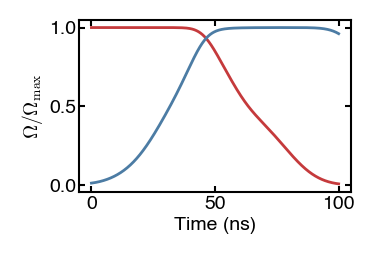

In [15]:
fig, ax = getStylishFigureAxes(1, 1)

# Plot Rabi_2 amplitude
PlotPlotter(
    fig, ax, tlist / 1e-9, Rabi_2_amplitude,
    style={
        'label': r'$\Omega_2$', 'marker': '',
        'linestyle': '-', 'linewidth': 1
    },
).draw()

# Plot Rabi_1 amplitude
PlotPlotter(
    fig, ax, tlist / 1e-9, Rabi_1_amplitude,
    style={
        'label': r'$\Omega_1$', 'marker': '',
        'linestyle': '-', 'linewidth': 1
    },
).draw()

ax.set_ylabel(r'$\Omega/\Omega_{\text{max}}$')
ax.set_xlabel('Time (ns)')

plt.show()

### Phase plot

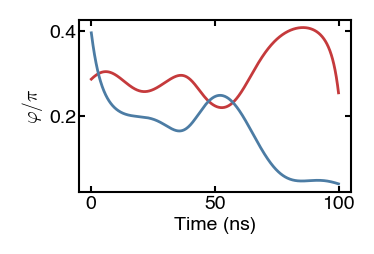

In [18]:
fig, ax = getStylishFigureAxes(1, 1)

# Plot Rabi_2 phase
PlotPlotter(
    fig, ax, tlist / 1e-9, Rabi_2_phase / np.pi,
    style={
        'label': r'$\varphi_2$', 'marker': '',
        'linestyle': '-', 'linewidth': 1
    },
).draw()

# Plot Rabi_1 phase
PlotPlotter(
    fig, ax, tlist / 1e-9, Rabi_1_phase / np.pi,
    style={
        'label': r'$\varphi_1$', 'marker': '',
        'linestyle': '-', 'linewidth': 1
    },
).draw()

ax.set_ylabel(r'$\varphi/\pi$')
ax.set_xlabel('Time (ns)')

plt.show()


### Plot dark state overlap

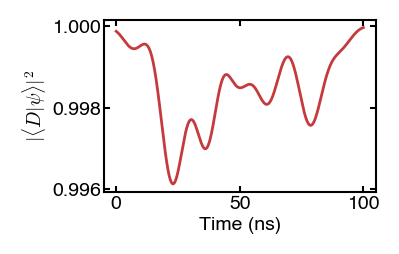

In [17]:
fig, ax = getStylishFigureAxes(1, 1)

# Plot dark state overlap
PlotPlotter(
    fig, ax, tlist / 1e-9, DS_overlap_squared,
    style={
        'linestyle': '-', 'linewidth': 1, 'marker': '',
    },
).draw()

ax.set_ylabel(r'$|\langle D|\psi\rangle|^2$')
ax.set_xlabel('Time (ns)')

plt.show()